In [31]:
import numpy as np
import pandas as pd 
import os
import json
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Standard plotly imports
import plotly.graph_objs as go
from plotly.offline import iplot

import altair as alt

from IPython.display import HTML

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time

import scipy as sp
from scipy import stats

# Standard plotly imports
#import plotly.plotly as py
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

import gc

In [32]:
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [33]:
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv')

# let's combine the data and work with the whole dataset
df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
df_test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Save variables to files
joblib.dump(train_transaction, '../variables/train_transaction.pkl')
joblib.dump(test_transaction, '../variables/test_transaction.pkl') 
joblib.dump(train_identity, '../variables/train_identity.pkl') 
joblib.dump(test_identity, '../variables/test_identity.pkl')  
joblib.dump(sample_submission, '../variables/sample_submission.pkl') 
joblib.dump(df_train, '../variables/df_train.pkl') 
joblib.dump(df_test, '../variables/df_test.pkl') 

['../variables/df_test.pkl']

In [27]:
train_transaction = train_transaction.reset_index(drop=True)


In [28]:
resumetable(train_transaction[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float64,0,1657,1.0,1.0,1.0,2.72
1,C2,float64,0,1216,1.0,1.0,1.0,2.75
2,C3,float64,0,27,0.0,0.0,0.0,0.04
3,C4,float64,0,1260,0.0,0.0,0.0,1.12
4,C5,float64,0,319,0.0,0.0,0.0,2.06
5,C6,float64,0,1328,1.0,1.0,1.0,2.52
6,C7,float64,0,1103,0.0,0.0,0.0,0.71
7,C8,float64,0,1253,0.0,0.0,0.0,1.25
8,C9,float64,0,205,1.0,0.0,1.0,2.62
9,C10,float64,0,1231,0.0,0.0,0.0,1.23


In [9]:
print(f'Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.')
print(f'Test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns.')

Train dataset has 590540 rows and 433 columns.
Test dataset has 506691 rows and 432 columns.


In [10]:
print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         6.08MB
test_identity.csv             25.8MB
test_transaction.csv          613.19MB
train_identity.csv            26.53MB
train_transaction.csv         683.35MB


In [11]:
## REducing memory
train_transaction = reduce_mem_usage(train_transaction)
train_identity= reduce_mem_usage(train_identity)

Mem. usage decreased to 540.09 Mb (69.5% reduction)
Mem. usage decreased to 26.41 Mb (41.5% reduction)


In [12]:
resumetable(train_transaction[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [13]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [84]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:20])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
dtype: int64
% of missing data =  41.17794374769424


In [15]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [53]:
train_transaction['isFraud'] = train_transaction['isFraud'].astype(int)
print(train_transaction.shape)
print(train_transaction['isFraud'].isna().sum())
print(train_transaction['isFraud'].value_counts())

(590540, 393)
0
isFraud
0    569877
1     20663
Name: count, dtype: int64


In [16]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


DeviceInfo
Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: count, dtype: int64

NameError: name 'total' is not defined

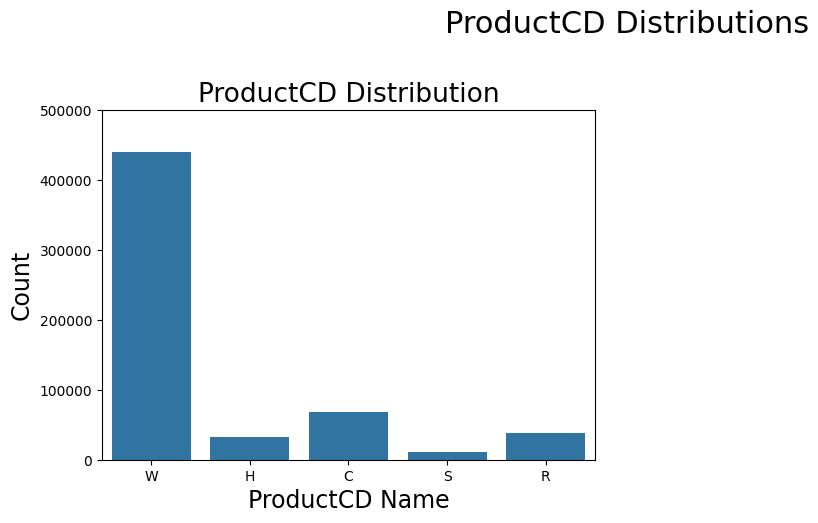

In [42]:
tmp = pd.crosstab(df_train['ProductCD'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_train[df_train['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

C:\Users\Marek\AppData\Local\Temp\ipykernel_12216\2605651191.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Marek\AppData\Local\Temp\ipykernel_12216\2605651191.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



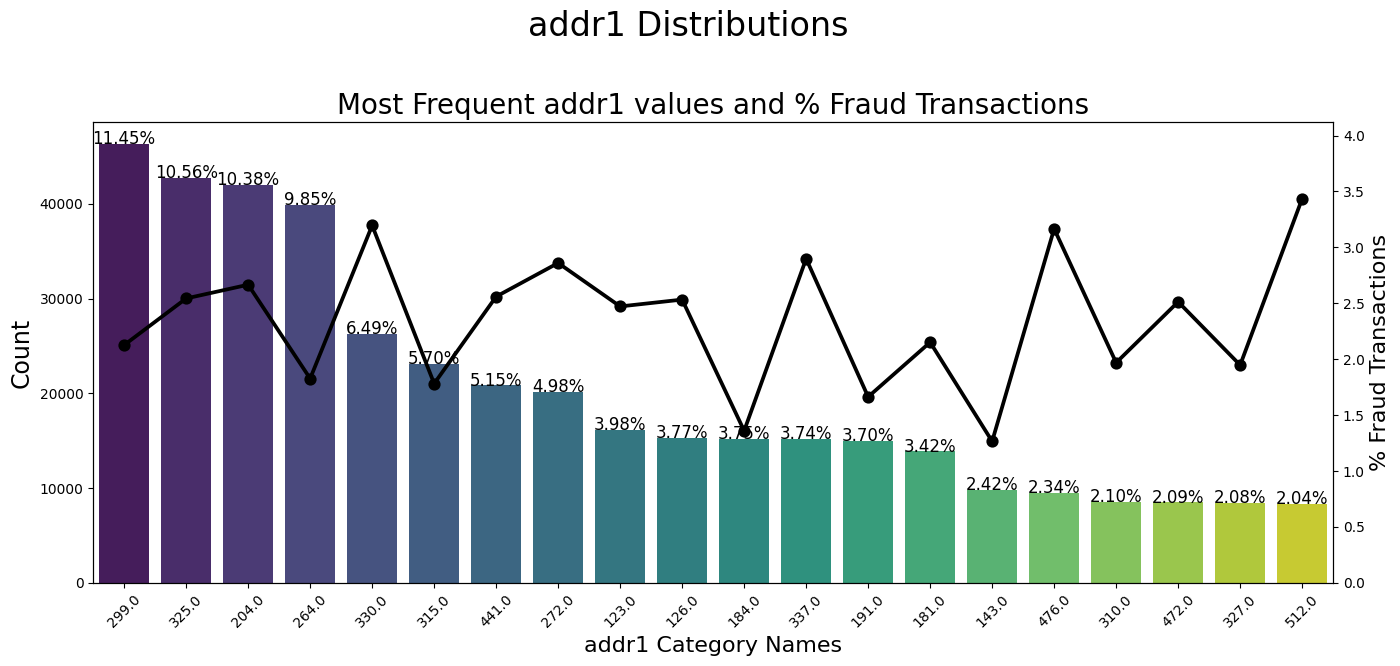

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def ploting_cnt_amt(df, col, top_n=20):
    # Get top N most frequent values
    top_values = df[col].value_counts().index[:top_n]
    df_filtered = df[df[col].isin(top_values)]
    
    # Compute fraud percentage
    tmp = pd.crosstab(df_filtered[col], df_filtered['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    plt.figure(figsize=(16, 14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    # Countplot
    plt.subplot(211)
    g = sns.countplot(x=col, data=df_filtered, order=top_values, palette="viridis")

    # Twin axis for fraud percentage line
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=top_values,
                       color='black', legend=False)
    gt.set_ylim(0, tmp['Fraud'].max() * 1.2)
    gt.set_ylabel("% Fraud Transactions", fontsize=16)
    
    # Add percentage labels to bars
    total = len(df_filtered)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width() / 2., height + 3,
               '{:1.2f}%'.format((height / total) * 100),
               ha="center", fontsize=12, color="black")

    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

    plt.subplots_adjust(hspace=0.4, top=0.9)
    plt.show()

ploting_cnt_amt(df_train, 'addr1', top_n=20)


In [23]:
# Define email domain groups
google_domains = ['gmail.com', 'gmail']
yahoo_domains = ['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de', 'yahoo.fr', 'yahoo.es']
microsoft_domains = ['hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 
                     'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'outlook.es', 
                     'live.com', 'live.fr', 'hotmail.fr']

# Map known email domains to categories
train_transaction['P_emaildomain'] = train_transaction['P_emaildomain'].replace(google_domains, 'Google')
train_transaction['P_emaildomain'] = train_transaction['P_emaildomain'].replace(yahoo_domains, 'Yahoo Mail')
train_transaction['P_emaildomain'] = train_transaction['P_emaildomain'].replace(microsoft_domains, 'Microsoft')

# Group less frequent email domains (<= 500 occurrences) into "Others"
domain_counts = train_transaction['P_emaildomain'].value_counts()
rare_domains = domain_counts[domain_counts <= 500].index
train_transaction.loc[train_transaction['P_emaildomain'].isin(rare_domains), 'P_emaildomain'] = "Others"

# Fill NaN values with "NoInf"
train_transaction['P_emaildomain'].fillna("NoInf", inplace=True)


C:\Users\Marek\AppData\Local\Temp\ipykernel_12216\2032332072.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





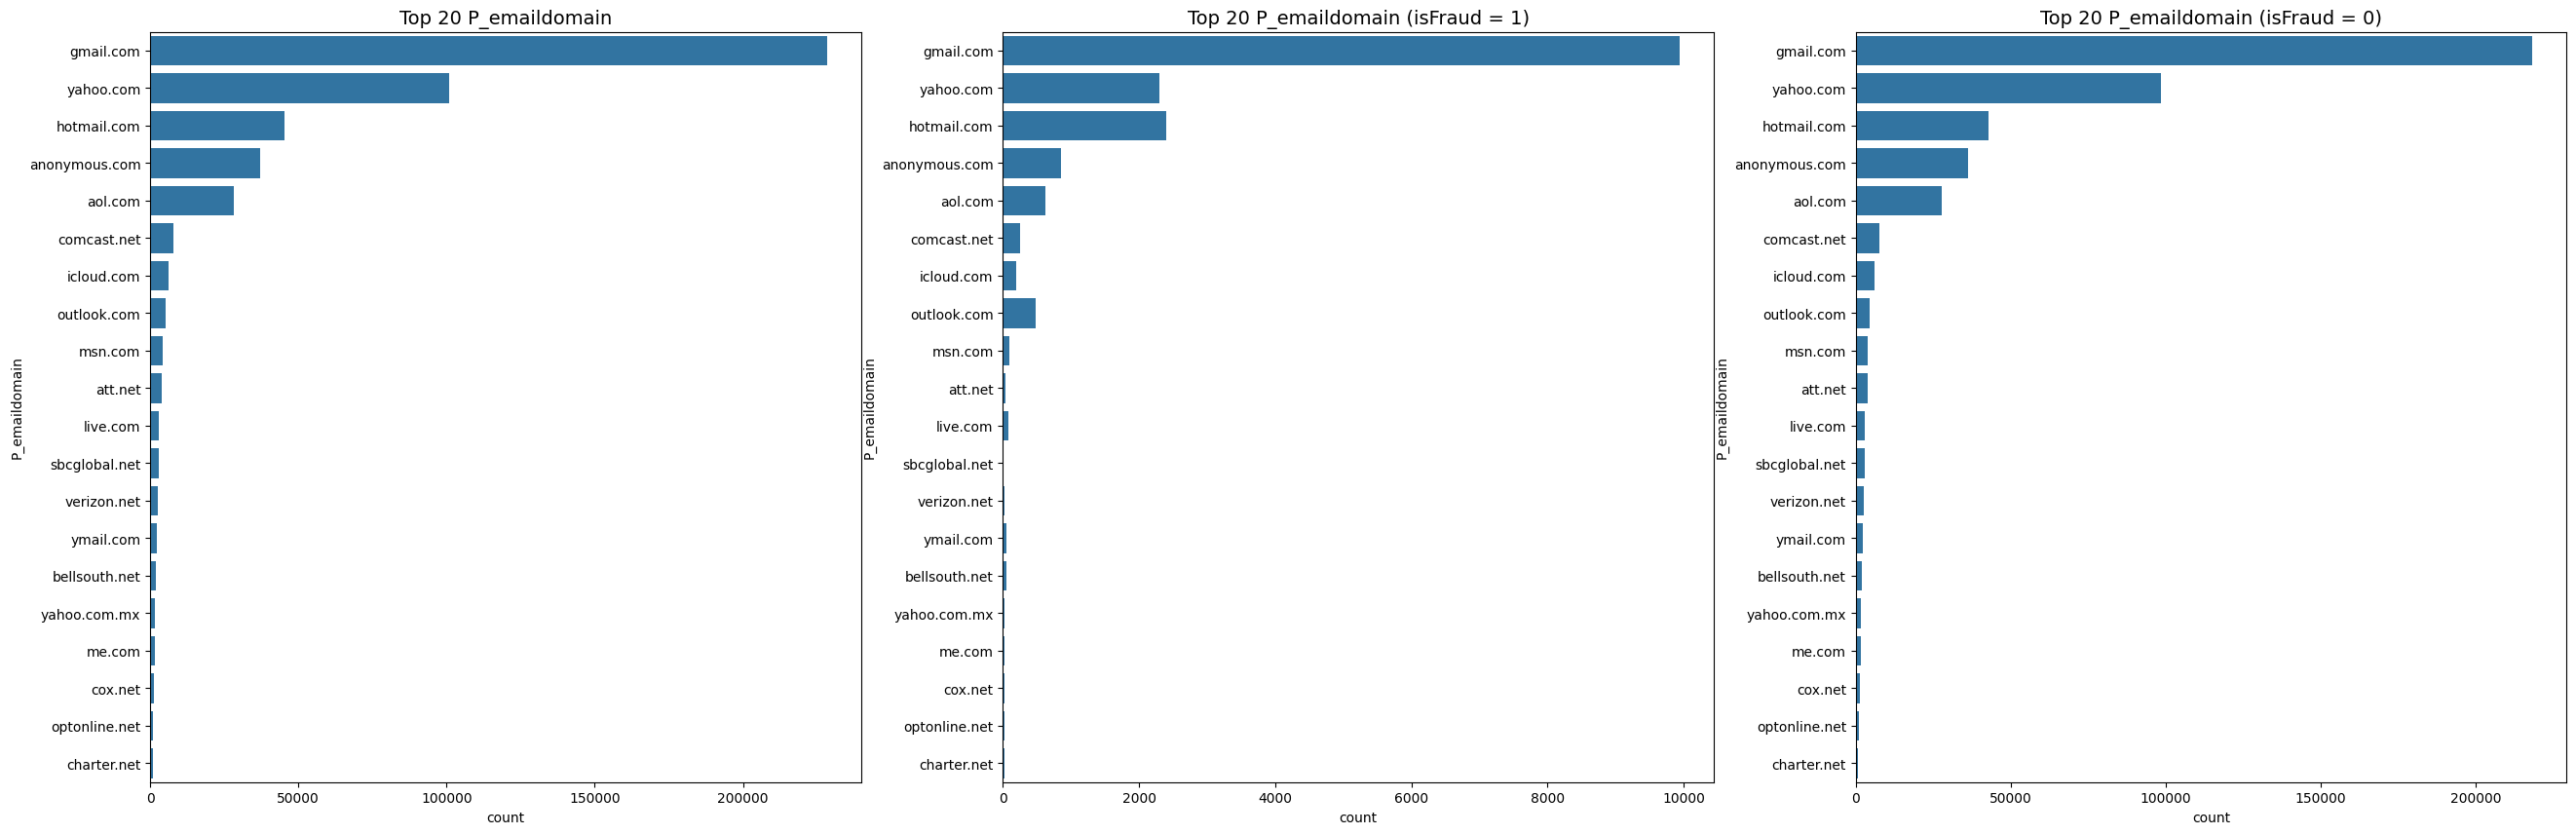

In [18]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(32, 10))

# Get the top 20 most common P_emaildomain values
top_20_domains = train_transaction["P_emaildomain"].value_counts().nlargest(20).index

# Filter dataset to keep only top 20 values
filtered_data = train_transaction[train_transaction["P_emaildomain"].isin(top_20_domains)]

# Plot for all transactions
sns.countplot(y="P_emaildomain", ax=ax[0], data=filtered_data, order=top_20_domains)
ax[0].set_title('Top 20 P_emaildomain', fontsize=14)

# Plot for fraudulent transactions (isFraud == 1)
fraud_data = filtered_data[filtered_data['isFraud'] == 1]
sns.countplot(y="P_emaildomain", ax=ax[1], data=fraud_data, order=top_20_domains)
ax[1].set_title('Top 20 P_emaildomain (isFraud = 1)', fontsize=14)

# Plot for non-fraudulent transactions (isFraud == 0)
non_fraud_data = filtered_data[filtered_data['isFraud'] == 0]
sns.countplot(y="P_emaildomain", ax=ax[2], data=non_fraud_data, order=top_20_domains)
ax[2].set_title('Top 20 P_emaildomain (isFraud = 0)', fontsize=14)

# Display the plots
plt.show()


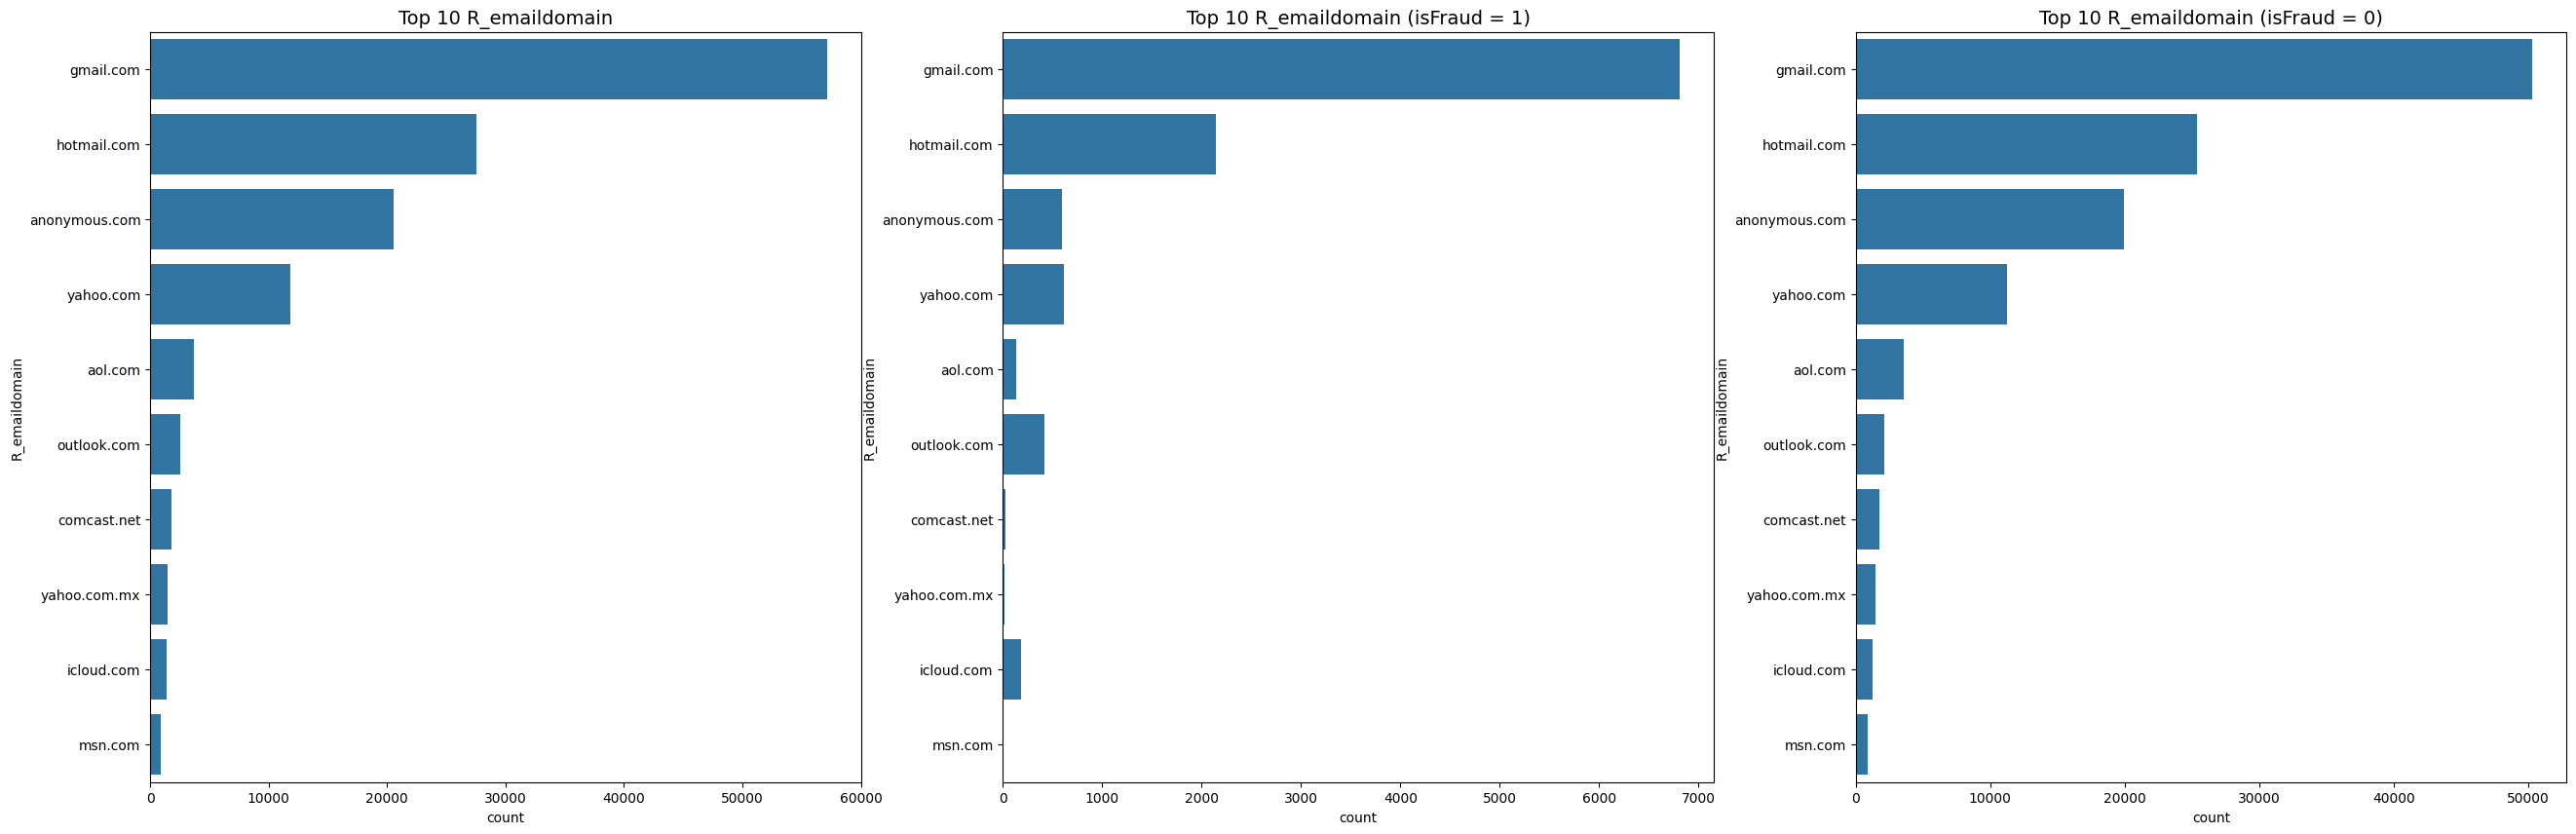

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(32, 10))

# Get the top 10 most common R_emaildomain values
top_10_domains = train_transaction["R_emaildomain"].value_counts().nlargest(10).index

# Filter dataset to keep only top 10 values
filtered_data = train_transaction[train_transaction["R_emaildomain"].isin(top_10_domains)]

# Plot for all transactions
sns.countplot(y="R_emaildomain", ax=ax[0], data=filtered_data, order=top_10_domains)
ax[0].set_title('Top 10 R_emaildomain', fontsize=14)

# Plot for fraudulent transactions (isFraud == 1)
fraud_data = filtered_data[filtered_data['isFraud'] == 1]
sns.countplot(y="R_emaildomain", ax=ax[1], data=fraud_data, order=top_10_domains)
ax[1].set_title('Top 10 R_emaildomain (isFraud = 1)', fontsize=14)

# Plot for non-fraudulent transactions (isFraud == 0)
non_fraud_data = filtered_data[filtered_data['isFraud'] == 0]
sns.countplot(y="R_emaildomain", ax=ax[2], data=non_fraud_data, order=top_10_domains)
ax[2].set_title('Top 10 R_emaildomain (isFraud = 0)', fontsize=14)

# Display the plots
plt.show()


In [19]:

charts = {}

# List of categorical features
features = ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

# Generate bar charts for each feature
for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
        y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
        x=alt.X('count:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, 'count']
    ).properties(title=f"Counts of {i}", width=400, height=300)
    
    charts[i] = chart

# Corrected layout (ensuring no duplicates)
final_chart = (
    (charts['ProductCD'] | charts['card4']) & 
    (charts['card6'] | charts['M4']) & 
    (charts['M1'] | charts['M2']) & 
    (charts['M3'] | charts['M5']) & 
    (charts['M6'] | charts['M7']) & 
    (charts['M8'] | charts['M9'])
)

# Display the chart
final_chart.display()


NameError: name 'train' is not defined

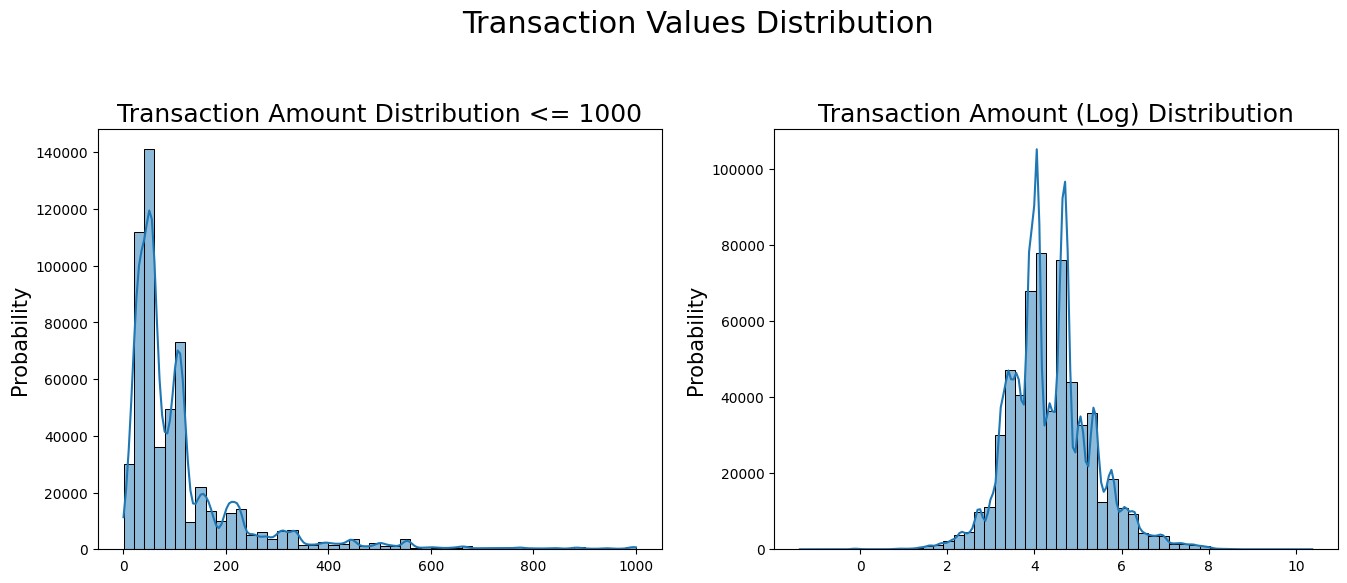

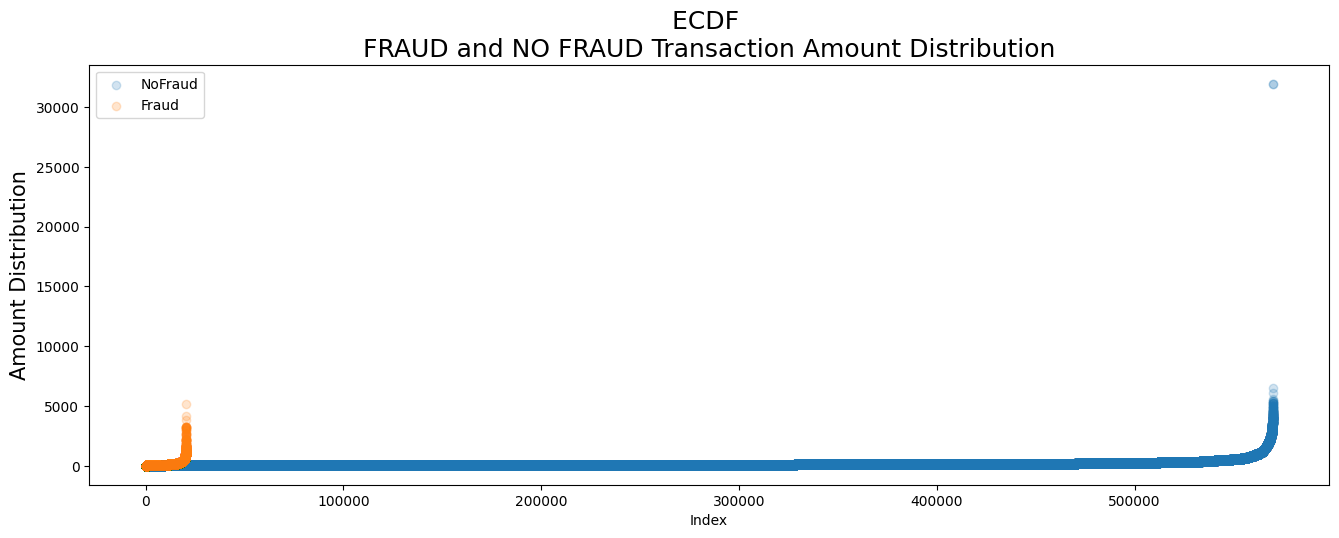

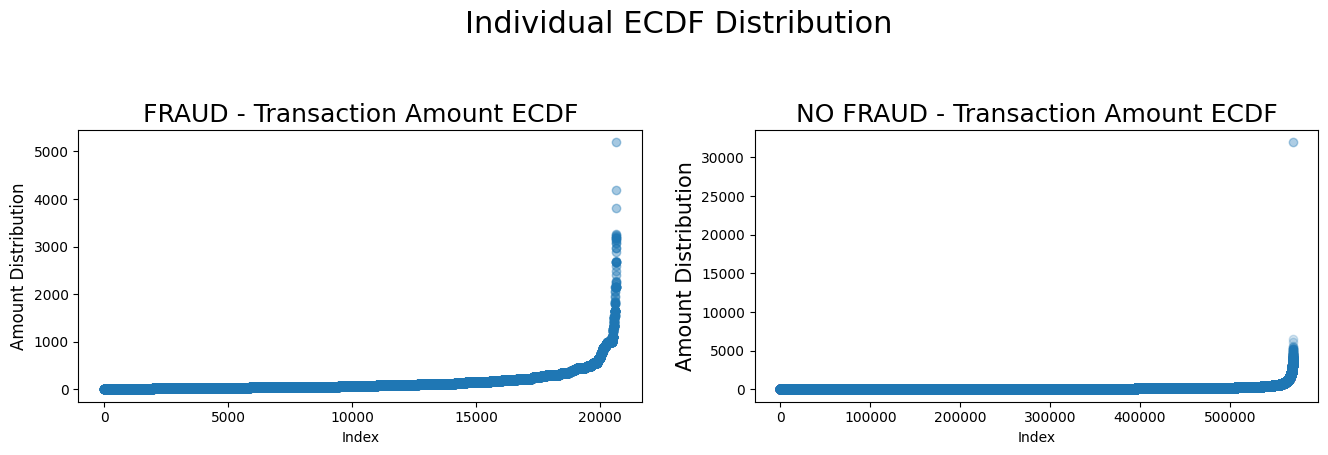

In [21]:
# Set figure size
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)

# Histogram for TransactionAmt <= 1000
plt.subplot(221)
g = sns.histplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'], kde=True, bins=50)
g.set_title("Transaction Amount Distribution <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

# Log-transformed TransactionAmt histogram
plt.subplot(222)
g1 = sns.histplot(np.log(train_transaction['TransactionAmt']), kde=True, bins=50)
g1.set_title("Transaction Amount (Log) Distribution", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

# New Figure for ECDF (Empirical Cumulative Distribution Function)
plt.figure(figsize=(16,12))

plt.subplot(212)
plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
            np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
            label='NoFraud', alpha=0.2)
plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
            np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
            label='Fraud', alpha=0.2)
plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=15)
plt.legend()

# New Figure for Individual ECDF
plt.figure(figsize=(16,12))

plt.subplot(321)
plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
            np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
            label='isFraud', alpha=0.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
            np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
            label='NoFraud', alpha=0.2)
plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()


In [11]:
CalcOutliers(train_transaction['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10093
Total outlier observations: 10093
Non-outlier observations: 580447
Total percentual of Outliers:  1.7388


In [20]:
train_transaction.loc[train_transaction['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_transaction.loc[train_transaction['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_transaction.loc[train_transaction['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train_transaction.loc[train_transaction['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train_transaction['id_30'].fillna("NAN", inplace=True)

KeyError: 'id_30'

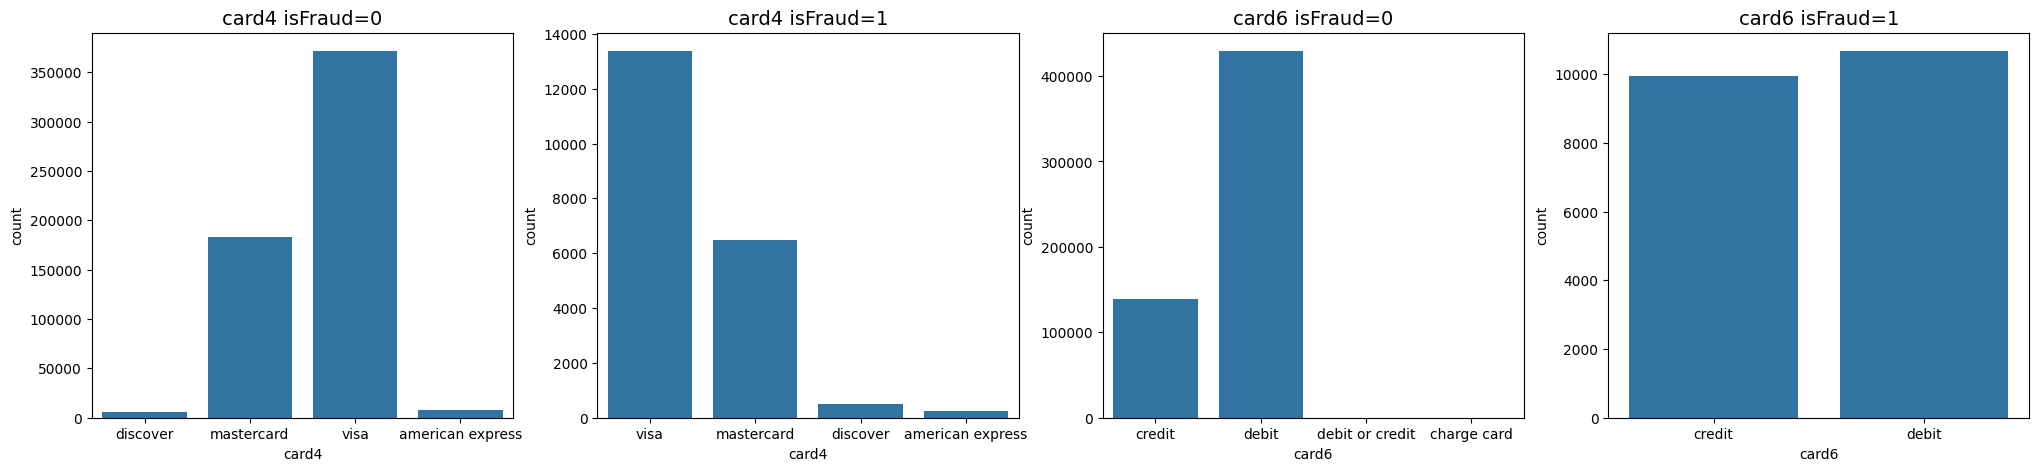

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

In [17]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

In [25]:
train_transaction.loc[train_transaction['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_transaction.loc[train_transaction['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_transaction.loc[train_transaction['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train_transaction.loc[train_transaction['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train_transaction['id_30'].fillna("NAN", inplace=True)

KeyError: 'id_30'

In [26]:
ploting_cnt_amt(train_transaction, 'id_30')

KeyError: 'id_30'